In [423]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
pd.set_option('display.max_columns', None)

In [ ]:
# Load the dataset from the CSV file
electricity_and_weather = pd.read_csv('../data/DATASET_final_untransformed_uncleaned.csv', sep=";")

# Convert the 'Date' column to datetime format for easier handling of time-based data
electricity_and_weather["Date"] = pd.to_datetime(electricity_and_weather["Date"])

# Filter the dataset to only include data from June 1, 2018, onwards
# As reported by Celine, the global radiation dataset starts from this date
electricity_and_weather = electricity_and_weather.drop(
    electricity_and_weather[electricity_and_weather["Date"] < '2018-06-01'].index
)

# Set the 'Date' column as the index for the dataframe for time-based operations
electricity_and_weather.set_index("Date", inplace=True)

# Define valid ranges for each column, which will be used for cleaning the data
# Each column has a specified minimum and maximum range of acceptable values
valid_ranges = {
    'Air_Temperature': (-90, 60),  # Valid range for Air Temperature (°C)
    'Relative_Humidity': (0, 100),  # Valid range for Relative Humidity (%)
    'Visibility': (0, 10),  # Valid range for Visibility (CODE)
    'Air_Pressure_at_Station_Height': (870, 1085),  # Valid range for Air Pressure (hPa)
    'Cloud_Cover': (0, 8),  # Valid range for Cloud Cover (Eighths)
    'Daily_Precipitation_Height': (0, np.inf),  # Valid range for Precipitation (mm)
    'Snow_Height_Daily_Value': (0, np.inf),  # Valid range for Snow Height (cm)
    'Global_Radiation': (0.1, np.inf),  # Valid range for Global Radiation (W/m²)
    'Vapor_Pressure': (0, 70),  # Valid range for Vapor Pressure (hPa)
    'Dew_Point_Temperature': (-80, 30),  # Valid range for Dew Point Temperature (°C)
    'Wind_Direction': (0, 31),  # Valid range for Wind Direction (32-teilig)
    'Wind_Strength': (0, 12),  # Valid range for Wind Strength (Bft)
}

# Function to clean each column by setting values outside the valid range to NaN
# Arguments:
#   x: the data values of a column
#   col_name: the name of the column to check
def clean_column(x, col_name):
    # Retrieve the valid range for the current column from the dictionary
    min_val, max_val = valid_ranges.get(col_name, (None, None))
    
    # If valid range is specified, filter out values outside the range by replacing them with NaN
    if min_val is not None and max_val is not None:
        return x.where((x >= min_val) & (x <= max_val), np.nan)
    
    # If no valid range is provided, return the column as is
    return x

# Apply the cleaning function to all columns in the dataframe
for col in electricity_and_weather.columns:
    electricity_and_weather[col] = clean_column(electricity_and_weather[col], col)


In [426]:
# # Initialize KNNImputer with 8 nearest neighbors
# imputer = KNNImputer(n_neighbors=5, weights='distance')

# # Impute missing values and convert back to DataFrame with original columns
# electricity_and_weather_imputed = pd.DataFrame(imputer.fit_transform(electricity_and_weather), 
#                                                columns=electricity_and_weather.columns)

# # Restore the original index and update the original dataframe
# electricity_and_weather_imputed.index = electricity_and_weather.index
# electricity_and_weather = electricity_and_weather_imputed

In [431]:
from sklearn.experimental import enable_iterative_imputer  # This is necessary to enable IterativeImputer
from sklearn.impute import IterativeImputer

# Initialize IterativeImputer (MICE method)
imputer = IterativeImputer(max_iter=10, random_state=0)

# Impute missing values and convert back to DataFrame with original columns
electricity_and_weather_imputed = pd.DataFrame(imputer.fit_transform(electricity_and_weather), 
                                               columns=electricity_and_weather.columns)

# Restore the original index and update the original dataframe
electricity_and_weather_imputed.index = electricity_and_weather.index
electricity_and_weather = electricity_and_weather_imputed
electricity_and_weather.isna().sum()

Total (grid load) [MWh] Calculated resolutions       0
Residual load [MWh] Calculated resolutions           0
Hydro pumped storage [MWh] Calculated resolutions    0
Air_Temperature                                      0
Relative_Humidity                                    0
Visibility                                           0
Air_Pressure_at_Station_Height                       0
Cloud_Cover                                          0
Daily_Precipitation_Height                           0
Snow_Height_Daily_Value                              0
Global_Radiation                                     0
Vapor_Pressure                                       0
Dew_Point_Temperature                                0
Wind_Direction                                       0
Wind_Strength                                        0
dtype: int64

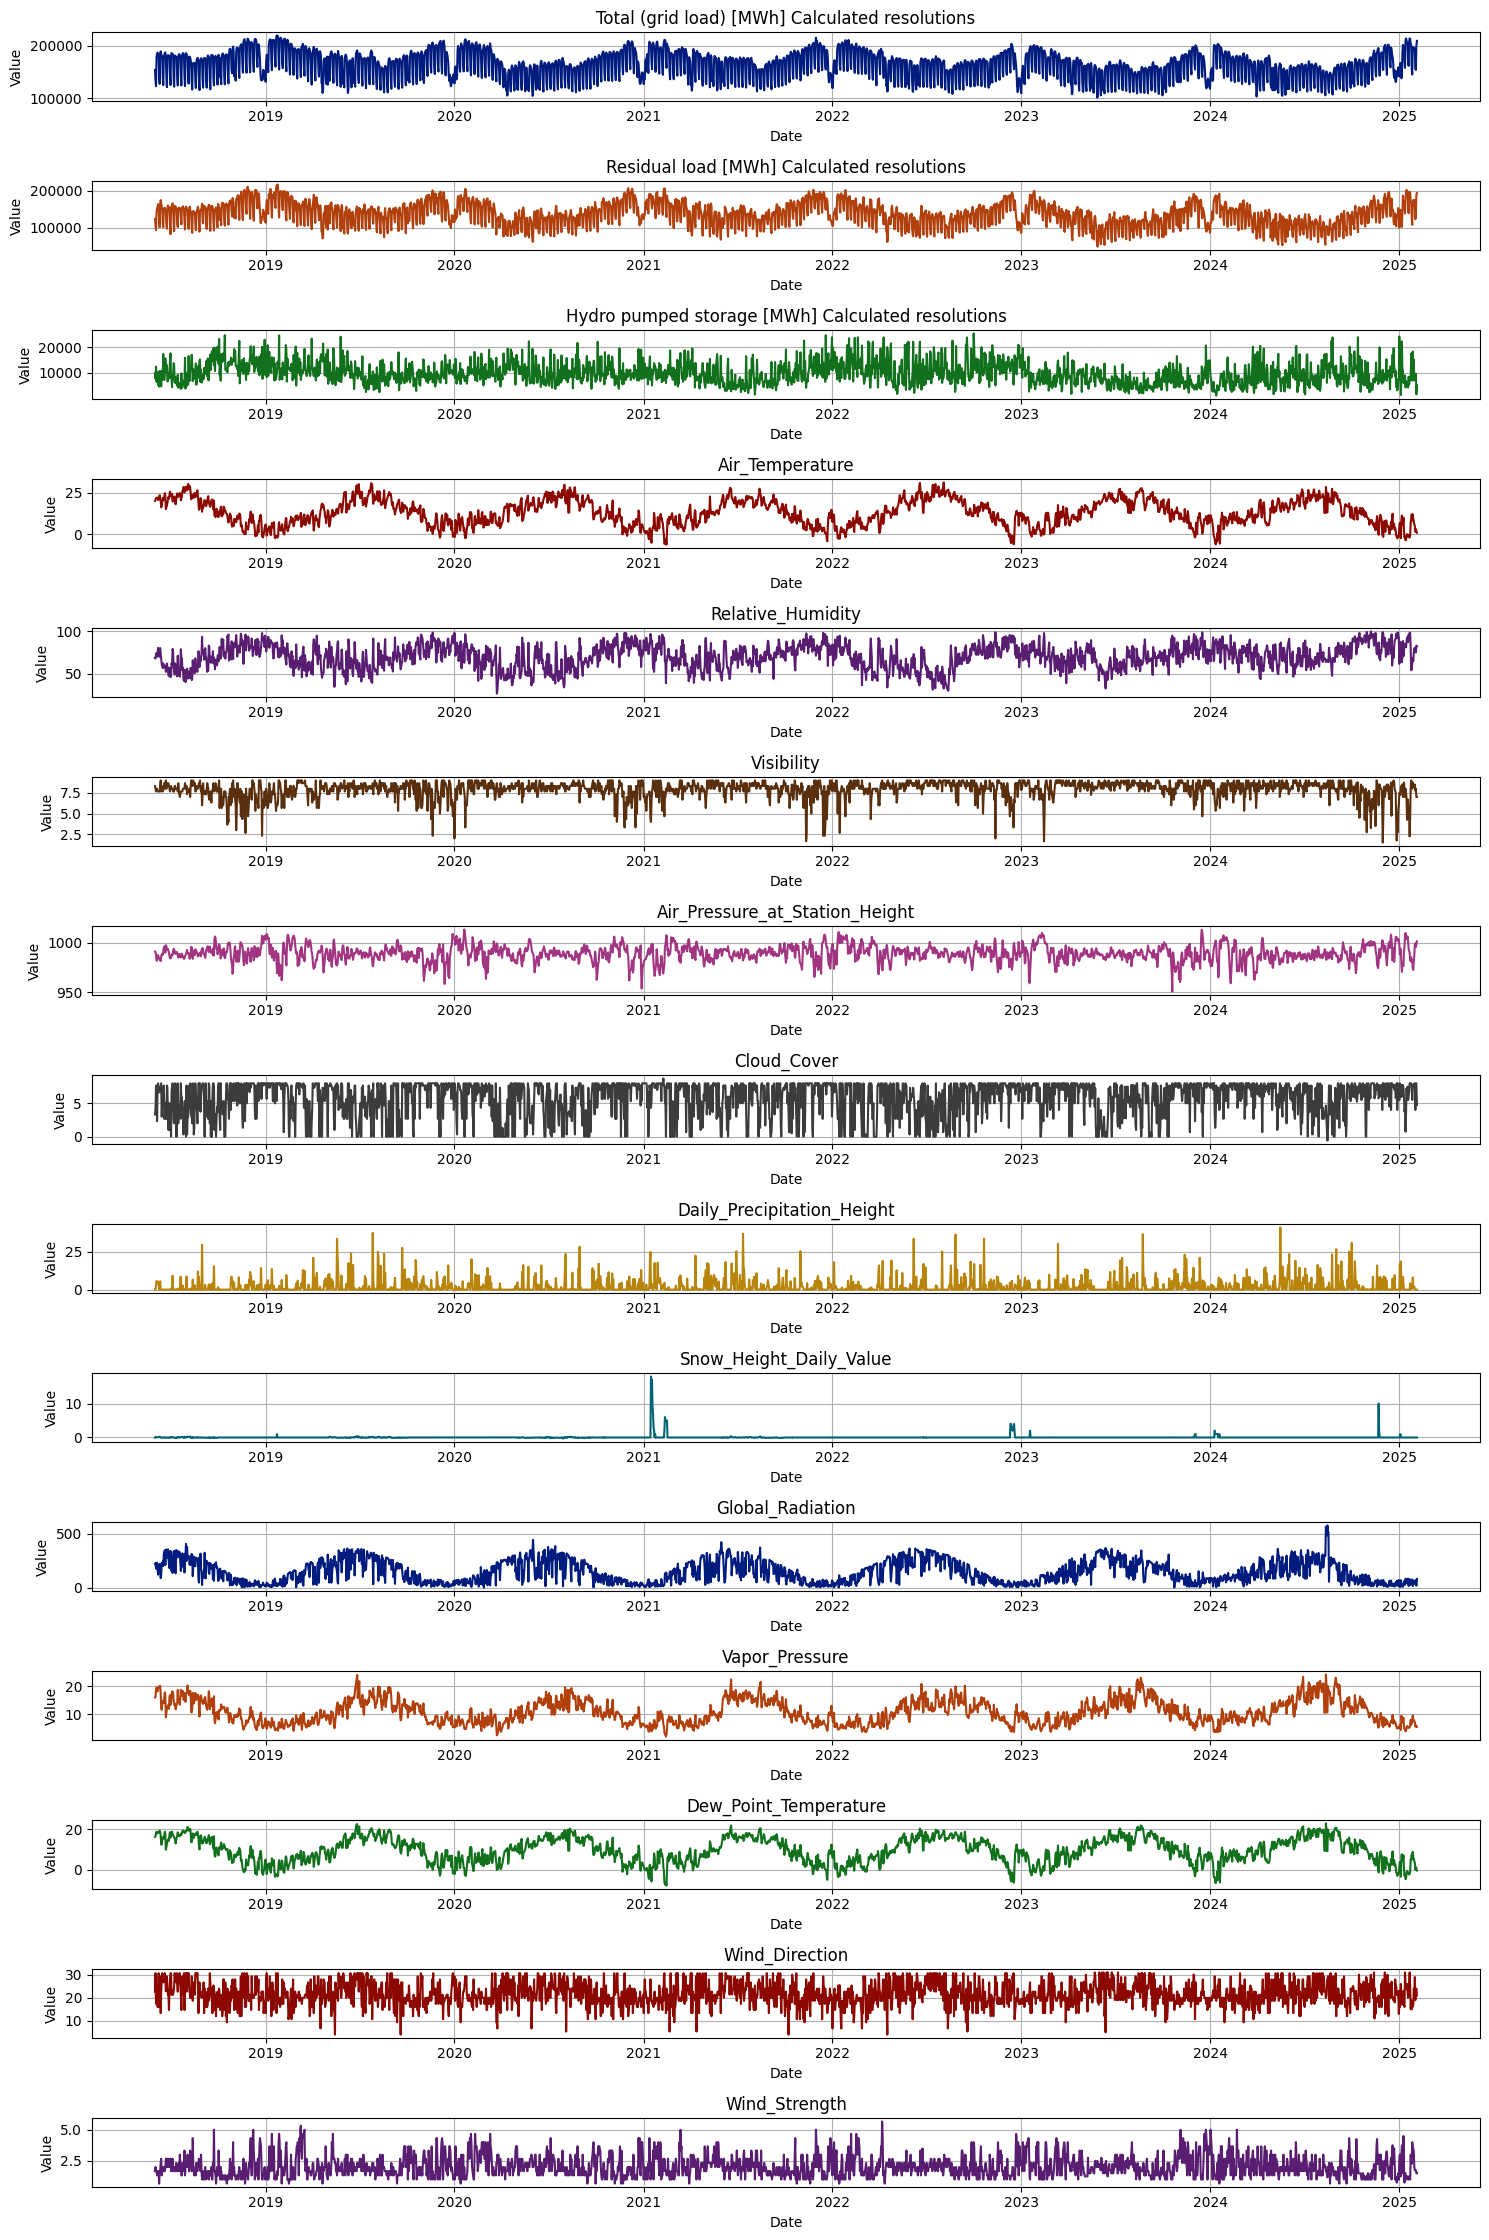

In [428]:
# Set up the figure and axes
num_columns = len(electricity_and_weather.columns)
fig, axes = plt.subplots(num_columns, 1, figsize=(num_columns, num_columns*1.5))  # Adjust figsize as needed

# Define a color palette (you can adjust the palette)
palette = sns.color_palette("dark", n_colors=num_columns)

# Loop through each column and plot it in the corresponding subplot with a different color
for i, column in enumerate(electricity_and_weather.columns):
    sns.lineplot(data=electricity_and_weather, x=electricity_and_weather.index, y=column, ax=axes[i], color=palette[i])
    axes[i].set_title(column)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Value')
    axes[i].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

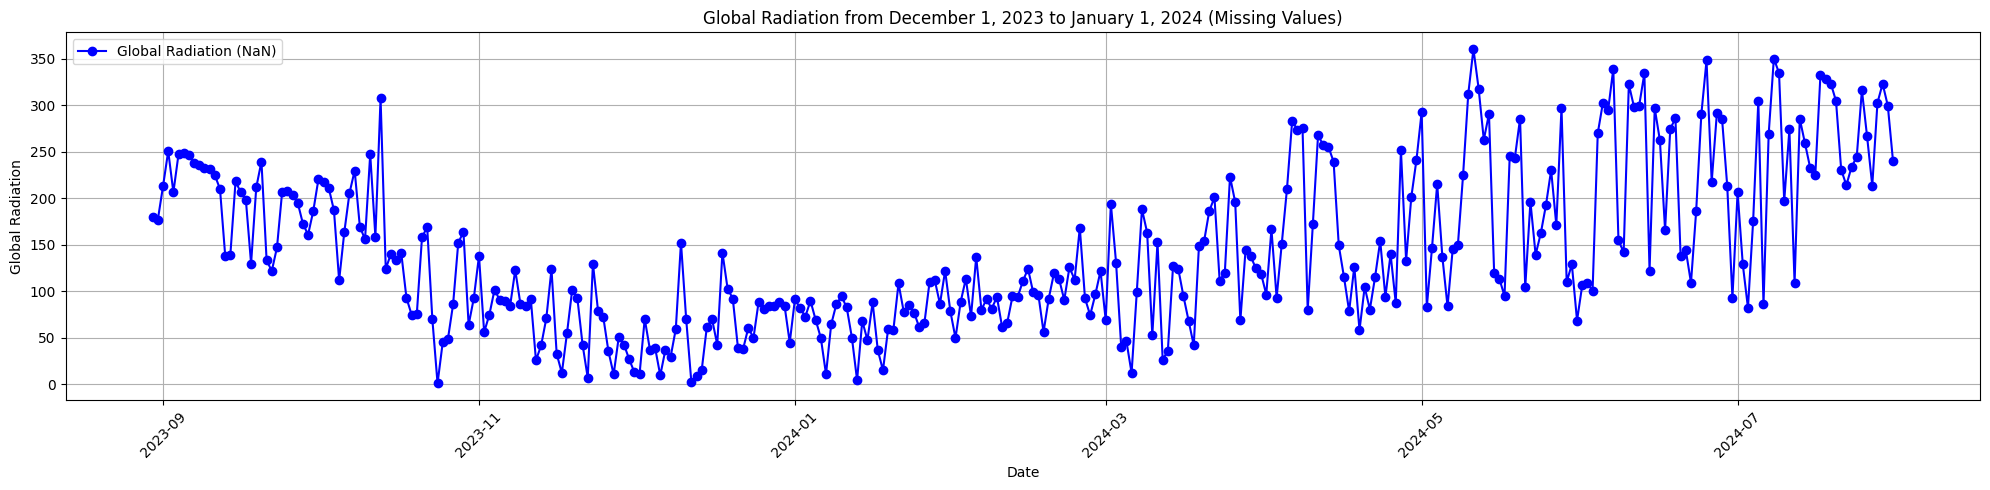

In [429]:
import matplotlib.pyplot as plt

# Filter the data (assuming you already did this step)
filtered_data = electricity_and_weather[
    # (electricity_and_weather['Global_Radiation'].isna()) &
    (electricity_and_weather.index >= '2023-08-30') &
    (electricity_and_weather.index <= '2024-07-31')
]

# Plotting the filtered data
plt.figure(figsize=(20, 5))
plt.plot(filtered_data.index, filtered_data['Global_Radiation'], marker='o', linestyle='-', color='b', label='Global Radiation (NaN)')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Global Radiation')
plt.title('Global Radiation from December 1, 2023 to January 1, 2024 (Missing Values)')
plt.legend()

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


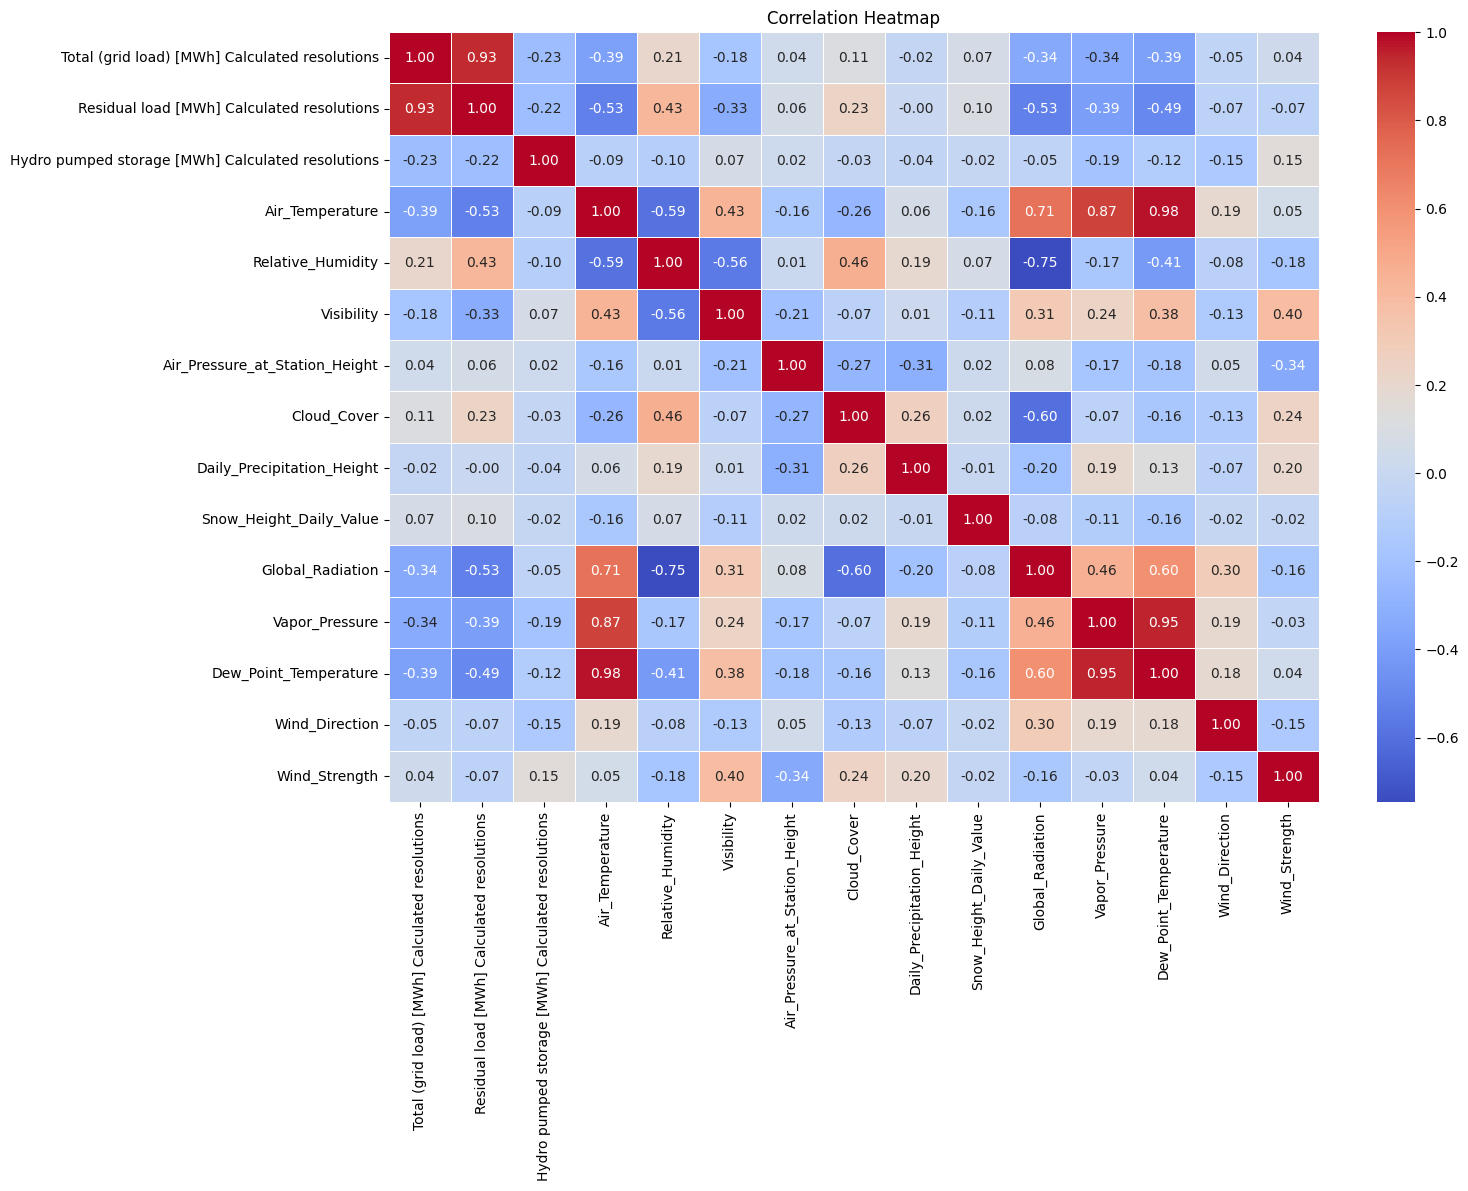

In [430]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Date as the index for correlation

# Create a correlation matrix
corr_matrix = electricity_and_weather.corr()
plt.figure(figsize=(15, 10))
# Create a heatmap to visualize the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.title('Correlation Heatmap')
plt.show()